In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, roc_curve, roc_auc_score)

In [2]:
df = pd.read_csv('telcoCustomerChurn.csv')

print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"\nFirst 5 rows:")
print(df.head())

Dataset loaded: 7043 rows, 21 columns

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSup

Dataset has 7,043 customers and 21 features \
Target variable is Churn (Yes/No) \
Mix of text and numbers

In [3]:
print("Data Info:")
print(df.info())

print("\n" + "="*50)
print("Missing Values:")
print(df.isnull().sum())


print("Target Variable (Churn):")
print(df['Churn'].value_counts())
print(f"\nChurn Rate: {(df['Churn']=='Yes').mean()*100:.1f}%")

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null

26.5% churn rate - about 1 in 4 customers left (imbalanced classes) \
TotalCharges is "object" (text) when it should be a number : BUG TO-DO \
18 text columns need converting to numbers \
TotalCharges has hidden issues

In [4]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Missing valeus
print(f"Missing in TotalCharges: {df['TotalCharges'].isnull().sum()}")

# Implace with median
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

df = df.drop('customerID', axis=1)

print(f"✓ Data cleaned")
print(f"New shape: {df.shape}")

Missing in TotalCharges: 11
✓ Data cleaned
New shape: (7043, 20)


Fixed TotalCharges (converted text → numbers, filled 11 missing values with median) \
Removed customerID as it isnt useful for prediction) \
Now we have clean data ready for modeling


In [5]:
print("Columns BEFORE encoding:")
print(df.dtypes)

Columns BEFORE encoding:
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object


In [6]:
y = df['Churn'].map({'Yes': 1, 'No': 0}) # Convert: Yes = 1, No = 0

cat_col = df.select_dtypes(include=['object']).columns.tolist()
cat_col.remove('Churn')

print(f"Text columns to convert: {len(cat_col)}")
print(cat_col)

# One-hot encode all text column. avoid redudndancy
df_encoded = pd.get_dummies(df, columns=cat_col, drop_first=True)

X = df_encoded.drop('Churn', axis=1)

print(f"Features (X): {X.shape[1]} columns")
print(f"Target (y): {y.shape[0]} rows")
print(X.dtypes)

Text columns to convert: 15
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Features (X): 30 columns
Target (y): 7043 rows
SeniorCitizen                              int64
tenure                                     int64
MonthlyCharges                           float64
TotalCharges                             float64
gender_Male                                 bool
Partner_Yes                                 bool
Dependents_Yes                              bool
PhoneService_Yes                            bool
MultipleLines_No phone service              bool
MultipleLines_Yes                           bool
InternetService_Fiber optic                 bool
InternetService_No                          bool
OnlineSecurity_No internet service          bool
OnlineSecurity_Yes                          bool

Converted churn to 1/0 \
Encoded 15 text columns into binary \
Separated X (features) and y (target)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} customers")
print(f"Test set: {X_test.shape[0]} customers")
print(f"Train churn rate: {y_train.mean()*100} %")
print(f"Test churn rate: {y_test.mean()*100} %")

Training set: 5634 customers
Test set: 1409 customers
Train churn rate: 26.53532126375577 %
Test churn rate: 26.54364797728886 %


Split data into 80% training (5,634 customers) and 20% testing (1,409 customers)

In [8]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15)

rf_model.fit(X_train, y_train)

print(f"Trees Cnt: 100")
print(f"Max depth: 15")

Trees Cnt: 100
Max depth: 15


Creates 100 decision trees, trains them on 5,634 customers \
Each tree sees random subset of data and features \
Each tree makes a prediction (churn: yes/no) \
Final prediction = majority vote (if 60 trees say "yes", customer will churn) \
Depth chosen randomly 

In [9]:
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

print("Predictions made on 1,409 test customers")
print(f"First 10 predictions:")
print(f"Actual:    {y_test.values[:10]}")
print(f"Predicted: {y_pred[:10]}")
print(f"Predicted {y_pred.sum()} customers will churn out of {len(y_pred)}")

Predictions made on 1,409 test customers
First 10 predictions:
Actual:    [0 0 0 0 0 0 0 0 0 1]
Predicted: [0 1 0 0 0 0 0 0 0 0]
Predicted 310 customers will churn out of 1409


Uses trained model to predict churn for 1,409 test customers \
Generates both hard predictions (0/1) and probability scores (vote percentages). \
Displays first 10 predictions vs actual values to verify model performance

In [10]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("MODEL PERFORMANCE:")
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"              Predicted")
print(f"              No    Yes")
print(f"Actual No   {cm[0,0]:4d}  {cm[0,1]:4d}")
print(f"Actual Yes  {cm[1,0]:4d}  {cm[1,1]:4d}")

MODEL PERFORMANCE:
Accuracy:  0.7928 (79.28%)
Precision: 0.6323
Recall:    0.5241
F1-Score:  0.5731

Confusion Matrix:
              Predicted
              No    Yes
Actual No    921   114
Actual Yes   178   196


Accuracy: 79.28% - 79% correct predictions \
Precision: 63.23% - Of predicted churners, 63% actually churned (37% false alarms) \
Recall: 52.41% - Caught 52% of actual churners (missed 48%) \
F1-Score: 57.31% - Harmonic mean of precision and recall 

Confusion Matrix: \
True Negatives (921): Correctly predicted no churn \
False Positives (114): Predicted churn but customer stayed \
False Negatives (178): Predicted stay but customer churned (costly error) \
True Positives (196): Correctly predicted churn \

AUC Score: 0.830899790746338


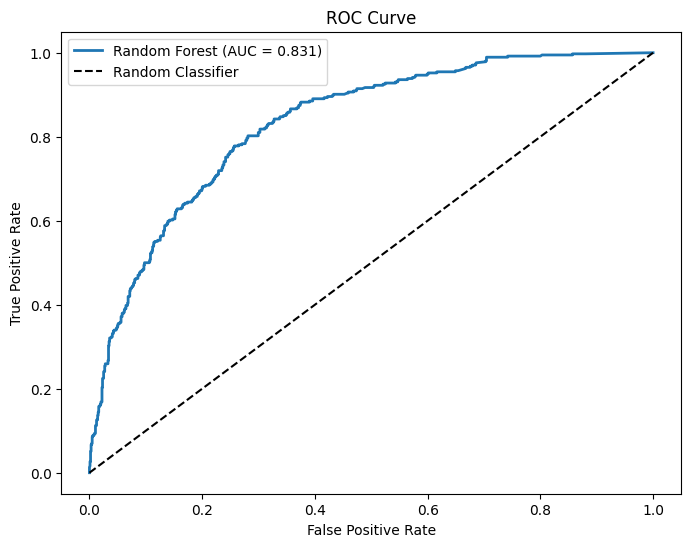

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"AUC Score: {auc}")


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

plot roc

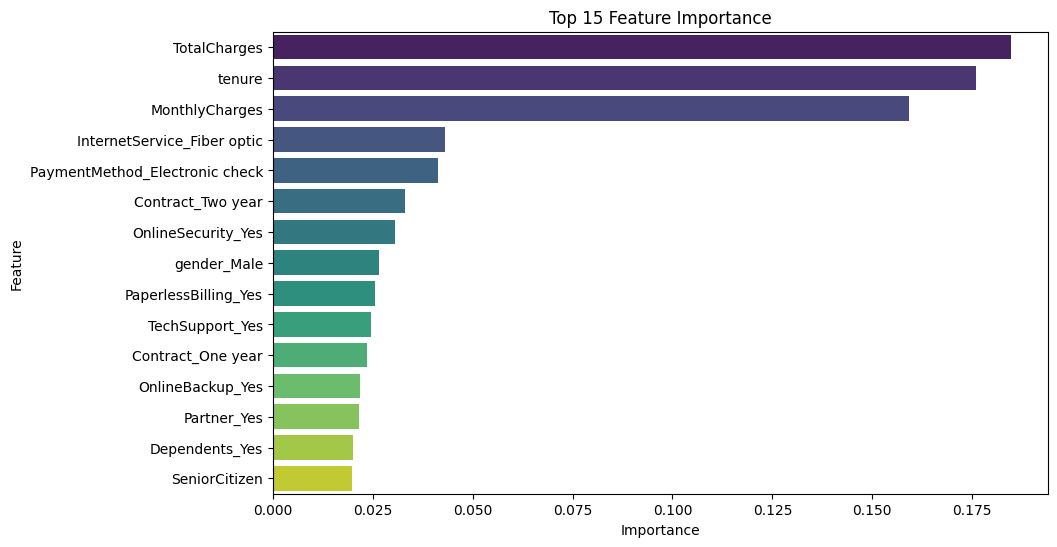

In [12]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance.head(15), y='Feature', x='Importance', palette='viridis')
plt.title('Top 15 Feature Importance')
plt.show()